# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from helper_functions import show_images, do_pca, scree_plot, plot_component

from sklearn.preprocessing import Imputer, StandardScaler,OneHotEncoder
from sklearn.decomposition import PCA

import re
import math
import time

from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

%reload_ext autoreload
%autoreload 2
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

### Exploratory Data Analysis


I use <b>`_azdias` </b> and <b>`_customers` </b> to follow the analytical process, and keep <b>`azdias`</b> and <b>`customers` </b> to apply the final clean_data function 

In [2]:
# Load in the general demographics data.
_azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

In [3]:
_customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [4]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [5]:
_azdias.shape

(891221, 85)

In [6]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
_azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [7]:
_azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
# check colums with all null or nan
nan = _azdias.isnull().all()
print(nan.any()) # False ok, no column has all rows null

nan = _azdias.isnull().all()
print(nan.any()) # False ok, no column has all rows null


False
False


In [9]:
# check if unique values in any column
def unique_cols(df):
    a = df.values # df.to_numpy() (pandas>0.24)
    return (a[0] == a).all(axis=0)

print(unique_cols(_azdias))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  after removing the cwd from sys.path.


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]


In [10]:
# another check if unique values in any column
for c in _azdias.columns:
    if _azdias[c].eq(_azdias[c].iloc[0]).all() :
        print(c)

In [11]:
feat_info

,attribute,information_level,type,missing_or_unknown,description
0,AGER_TYP,person,categorical,"[-1,0]",Best-ager typology
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",Estimated age based on given name analysis
2,ANREDE_KZ,person,categorical,"[-1,0]",Gender
3,CJT_GESAMTTYP,person,categorical,[0],Customer-Journey-Typology: preferred informati...
4,FINANZ_MINIMALIST,person,ordinal,[-1],"Financial typology, low financial interest"
5,FINANZ_SPARER,person,ordinal,[-1],"Financial typology, money-saver"
6,FINANZ_VORSORGER,person,ordinal,[-1],"Financial typology, be prepared"
7,FINANZ_ANLEGER,person,ordinal,[-1],"Financial typology, investor"
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],"Financial typology, inconspicuous"
9,FINANZ_HAUSBAUER,person,ordinal,[-1],"Financial typology, home ownership"


---
### Observations  
* Some atributes has no missing values code, we will convert them to np.nan
* Other atributes has unknown codes, we also wil convert to np.nan

---

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.

# Gets missing_or_unknown col string and convert to a list
def parse_misses(string):
    mylist= re.findall('[-]?[0-9X]+', string)
    return mylist


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
## Check naturally missing data

def get_nan_means(df, verbose=False):
    '''
    Get the means by cols with null values
    '''
    nan_means = df.isnull().mean()*100
    
    nan_means_df = pd.DataFrame({"attribute": df.columns,
                                     "missing": nan_means}).reset_index(drop=True)
    if verbose:
        print('% of Nan values')
        for i,v in nan_means.items():
            print('%.2f                %s ' % (v,i))
            
    return nan_means_df.sort_values(by=['missing'],ascending=False)

In [14]:
def replace_with_nan(val, missing):
    """Replaces unkown values with np.nan values if the value matches with the unkown representation"""
    # 'X' 'XX, ...
    if isinstance(val,str) and val in missing:
        return np.nan
    # '1','2'...
    if isinstance(val,int) and str(val) in missing:
        return np.nan
    # float values and NANs
    elif isinstance(val,float) and not math.isnan(val) and str(int(val)) in missing:
        return np.nan
    # else
    else:
        return val


In [15]:
def get_missing_codes(attr, df):
    string = df.loc[df.attribute == attr].missing_or_unknown.iloc[0] #Serie index
    return parse_misses(string)


In [16]:
def populate_nans(df,feat_info,verbose=False):
    '''
    It maps unknown/missing values by column and transform them to nan values.
    
    '''
    
    print('Replacing unknown/missing codes with NANs ........please wait ')
    
    # Looping through columns with unkown values:
    for i,att in enumerate(df.columns):
        miss = get_missing_codes(att,feat_info)
        if verbose:
            print("Replacing {} to NaN in Attribute {}".format(miss, att))
        else:
            if (i%10 == 0):
                print('%s ............... ok' % (i))

        df[att] = df[att].apply(replace_with_nan, args=[miss])


    print('...................... OK ')
    
    return df


In [17]:
# Check for nan replacement
_azdias.loc[np.isnan(_azdias['ALTERSKATEGORIE_GROB'])]
_azdias.loc[np.isnan(_azdias['AGER_TYP'])]
# OK

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB


## Cleaning the data



In [18]:
_azdias = populate_nans(_azdias, feat_info, verbose=True)
az_post_nans = get_nan_means(_azdias)

Replacing unknown/missing codes with NANs ........please wait 
Replacing ['-1', '0'] to NaN in Attribute AGER_TYP
Replacing ['-1', '0', '9'] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing ['-1', '0'] to NaN in Attribute ANREDE_KZ
Replacing ['0'] to NaN in Attribute CJT_GESAMTTYP
Replacing ['-1'] to NaN in Attribute FINANZ_MINIMALIST
Replacing ['-1'] to NaN in Attribute FINANZ_SPARER
Replacing ['-1'] to NaN in Attribute FINANZ_VORSORGER
Replacing ['-1'] to NaN in Attribute FINANZ_ANLEGER
Replacing ['-1'] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing ['-1'] to NaN in Attribute FINANZ_HAUSBAUER
Replacing ['-1'] to NaN in Attribute FINANZTYP
Replacing ['0'] to NaN in Attribute GEBURTSJAHR
Replacing [] to NaN in Attribute GFK_URLAUBERTYP
Replacing [] to NaN in Attribute GREEN_AVANTGARDE
Replacing ['-1', '0'] to NaN in Attribute HEALTH_TYP
Replacing ['0'] to NaN in Attribute LP_LEBENSPHASE_FEIN
Replacing ['0'] to NaN in Attribute LP_LEBENSPHASE_GROB
Replacing ['0'] to NaN in Attrib

In [19]:
_customers = populate_nans(_customers, feat_info, verbose=True)
cust_post_nans = get_nan_means(_customers)

Replacing unknown/missing codes with NANs ........please wait 
Replacing ['-1', '0'] to NaN in Attribute AGER_TYP
Replacing ['-1', '0', '9'] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing ['-1', '0'] to NaN in Attribute ANREDE_KZ
Replacing ['0'] to NaN in Attribute CJT_GESAMTTYP
Replacing ['-1'] to NaN in Attribute FINANZ_MINIMALIST
Replacing ['-1'] to NaN in Attribute FINANZ_SPARER
Replacing ['-1'] to NaN in Attribute FINANZ_VORSORGER
Replacing ['-1'] to NaN in Attribute FINANZ_ANLEGER
Replacing ['-1'] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing ['-1'] to NaN in Attribute FINANZ_HAUSBAUER
Replacing ['-1'] to NaN in Attribute FINANZTYP
Replacing ['0'] to NaN in Attribute GEBURTSJAHR
Replacing [] to NaN in Attribute GFK_URLAUBERTYP
Replacing [] to NaN in Attribute GREEN_AVANTGARDE
Replacing ['-1', '0'] to NaN in Attribute HEALTH_TYP
Replacing ['0'] to NaN in Attribute LP_LEBENSPHASE_FEIN
Replacing ['0'] to NaN in Attribute LP_LEBENSPHASE_GROB
Replacing ['0'] to NaN in Attrib

### Plot missing Data pre and post cleaned

In [20]:
# Investigate patterns in the amount of missing data in each column.

def plot_missing(df1, df2, percentage=0, figsize=(10,30)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    features and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    fig.suptitle("Missing Data percentages")

    ax = fig.add_subplot(121)
    ax.set_title("Azdias")
    sns.barplot(y="attribute", x="missing", 
                data=df1[df1.missing>percentage], ax= ax)

    ax = fig.add_subplot(122)
    ax.set_title("Customer")
    sns.barplot(y="attribute", x="missing", 
                data=df2[df2.missing>percentage], ax= ax)

    fig.tight_layout(rect=[0, 0.03, 1, 0.975])
#     fig.tight_layout()
    plt.show()

    


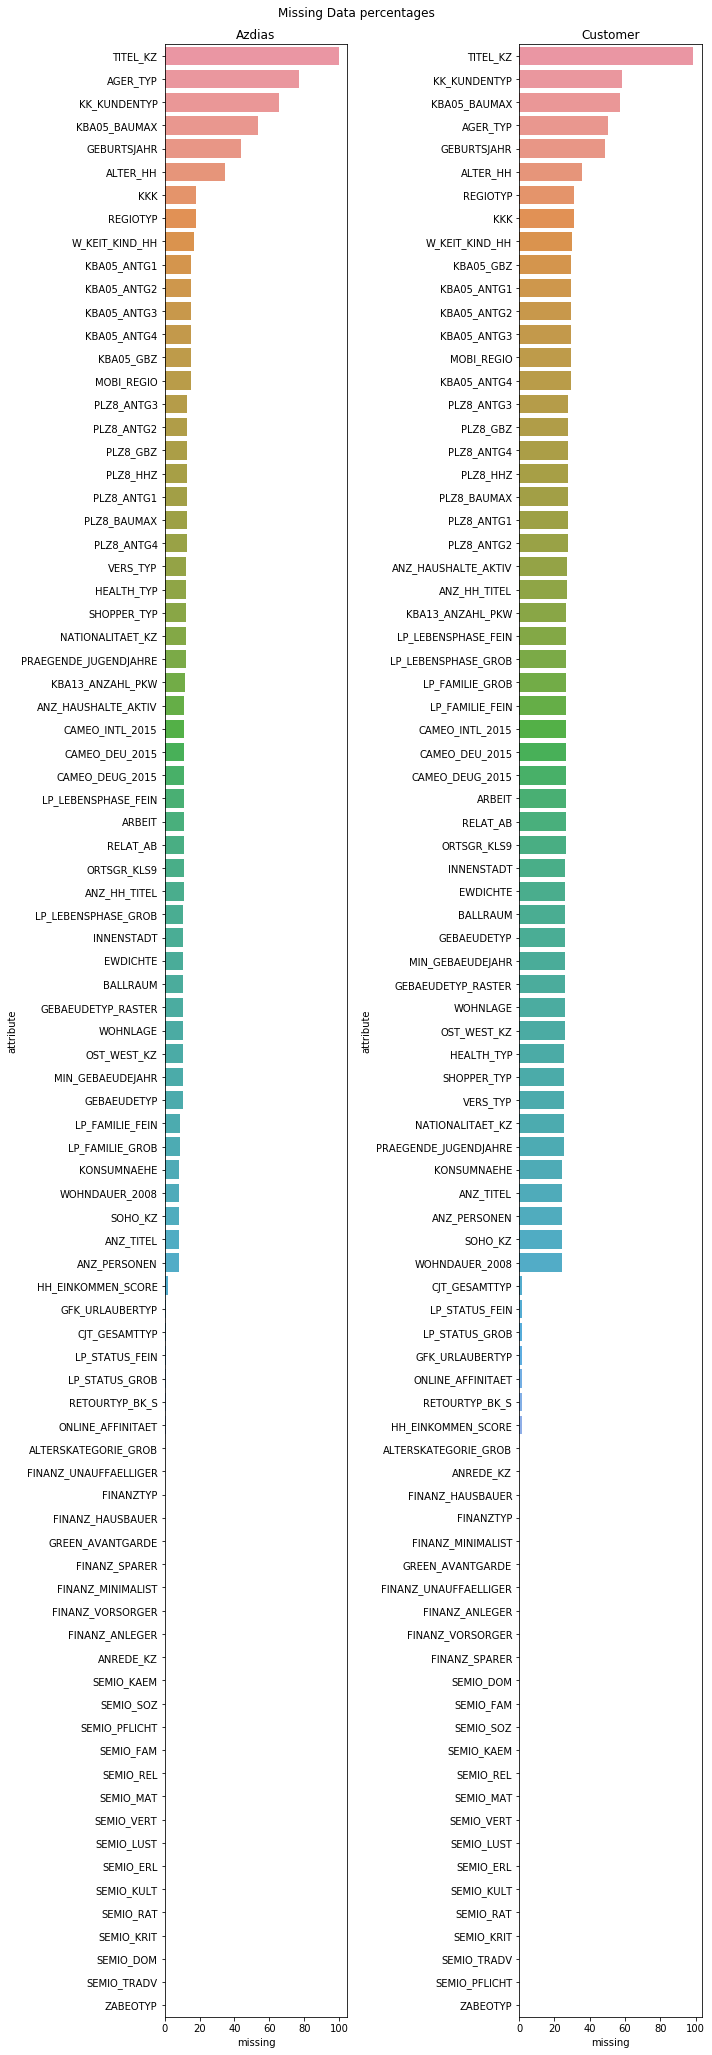

In [21]:
plot_missing(az_post_nans,cust_post_nans,percentage=-1)

In [22]:
az_post_nans.loc[az_post_nans['missing']>30]

,attribute,missing
40,TITEL_KZ,99.757636
0,AGER_TYP,76.955435
47,KK_KUNDENTYP,65.596749
64,KBA05_BAUMAX,53.468668
11,GEBURTSJAHR,44.020282
43,ALTER_HH,34.813699


In [23]:
cust_post_nans.loc[cust_post_nans['missing']>30]

,attribute,missing
40,TITEL_KZ,98.793647
47,KK_KUNDENTYP,58.406382
64,KBA05_BAUMAX,57.153069
0,AGER_TYP,50.475863
11,GEBURTSJAHR,48.537975
43,ALTER_HH,35.870745
73,REGIOTYP,31.340137
70,KKK,31.340137


In [24]:
az_post_nans.loc[az_post_nans['missing']==0]

,attribute,missing
8,FINANZ_UNAUFFAELLIGER,0.0
10,FINANZTYP,0.0
9,FINANZ_HAUSBAUER,0.0
13,GREEN_AVANTGARDE,0.0
5,FINANZ_SPARER,0.0
4,FINANZ_MINIMALIST,0.0
6,FINANZ_VORSORGER,0.0
7,FINANZ_ANLEGER,0.0
2,ANREDE_KZ,0.0
35,SEMIO_KAEM,0.0


In [25]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

dropped_cols = ['TITEL_KZ','KK_KUNDENTYP','KBA05_BAUMAX','ALTER_HH','AGER_TYP','GEBURTSJAHR']
_azdias.drop(columns = dropped_cols, axis=1,inplace=True)
_customers.drop(columns = dropped_cols, axis=1,inplace=True)

In [26]:
_azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

We observe 4 attributes with `> 30% missing data` for azdias and customer, so we decide to drop them out. They are 

---
         attribute	      missing
    40	TITEL_KZ	    99.757636
    0	AGER_TYP	    76.955435
    47	KK_KUNDENTYP	65.596749
    64	KBA05_BAUMAX	53.468668
    11	GEBURTSJAHR	    44.020282
    43	ALTER_HH	    34.813699

---

We find some pattern for attributes groups with similar missing % (`CAMEO`,`PLZ8`, `KBAD5`,`ANZ`) 

On the contrary, other attributes has no NANs at all (`FINANZ`,`SEMIO`)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [27]:
def plot_missing_by_rows(df1, df2,label_df1, label_df2, bins=40, figsize=(10,6)):
    """
    Takes in two dataframes and plots a barchart comparing two dataframes
    rows and percentage of missing values based on a threshold percentage given
    """
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title("Rows vs Missing features")
    ax.set_xlabel("Missing Features")
    ax.set_ylabel("Rows")
    sns.distplot(df1.isnull().sum(axis=1), bins, kde=False, ax=ax, label=label_df1)
    sns.distplot(df2.isnull().sum(axis=1), bins, kde=False, ax=ax, label=label_df2)
    ax.legend()
    
    plt.show()

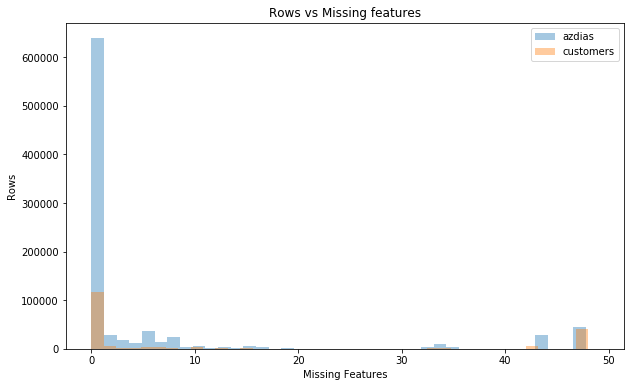

In [28]:
# How much data is missing in each row of the dataset?
plot_missing_by_rows(_azdias,_customers,'azdias','customers')

#### So lets set a threshold on 10 ...

In [29]:
# Divide the data into two subsets:
def split_outliers(df,threshold=10):
    total_rows= df.shape[0]
    
    outliers = df.loc[df.isnull().sum(axis=1)>10]
    df = df.loc[df.isnull().sum(axis=1)<=10]
    
    print('Removing %s outliers rows from df '% (len(outliers)))
    print('Remaining %s rows on df '% (len(df)))
    
    return df, outliers



In [30]:
_azdias, _az_outliers = split_outliers(_azdias)
# print(_azdias.shape)
# print(_az_outliers.shape)

Removing 111068 outliers rows from df 
Remaining 780153 rows on df 


In [31]:
_cust_outliers = split_outliers(_customers)

Removing 52584 outliers rows from df 
Remaining 139068 rows on df 


#### Lets plot azdias and outliers distribution of Nans attributes count.

Interestingly we see in the outliers almost 40000 (~40% of them, ~10% of the total dataset) have around 47 null attributes. 



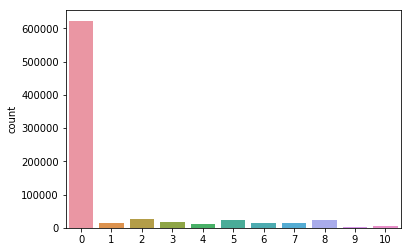

In [32]:
sns.countplot(_azdias.isnull().sum(axis=1))

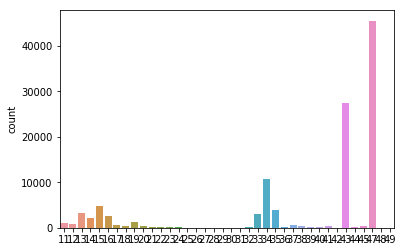

In [33]:
sns.countplot(_az_outliers.isnull().sum(axis=1))

#### Ploting Inliers and Outliers 

We choose Attributes with 0% missing data in the Dataset to contrast Inliers against Outliers behaviour
We can observe that the it differs quite a lot, having no correlation in almost anyone, so thats a result that reinforces the idea of discarding Outliers.

The Attributes choosen are  `'FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','GREEN_AVANTGARDE','FINANZ_SPARER','SEMIO_KAEM',`
 `'SEMIO_SOZ','SEMIO_PFLICHT','SEMIO_FAM','SEMIO_REL'`



In [34]:
#"In order to know what to do with the outlier rows, we should see if the distribution of data values on columns 
# that are not missing data (or are missing very little data) are similar or different between the two groups. 
# Select at least five of these columns and compare the distribution of values."

non_missing_columns = ['FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','GREEN_AVANTGARDE','FINANZ_SPARER',
                       'SEMIO_KAEM','SEMIO_SOZ','SEMIO_PFLICHT','SEMIO_FAM','SEMIO_REL']

In [35]:


def plot_cols_count_comparison(df,df2,label1,label2,features=[], figsize=(10,40)):
    """
    Same as plot_missing_by_rows but with features
    """
    title="Data Behaviour "
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)
    # squeeze avoid transforming in 1D when 1 only feature
    axes = fig.subplots(len(features),2, squeeze=False)
    
    for i,ff in enumerate(features):
        countplot_by_attr(df,ff,axes[i][0])
        countplot_by_attr(df2,ff,axes[i][1])
    
    for ax, col in zip(axes[0], [label1,label2]):
        ax.set_title(col)
    
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()
    
    
def countplot_by_attr(df,attr,ax):
    sns.countplot(df[attr],ax=ax)


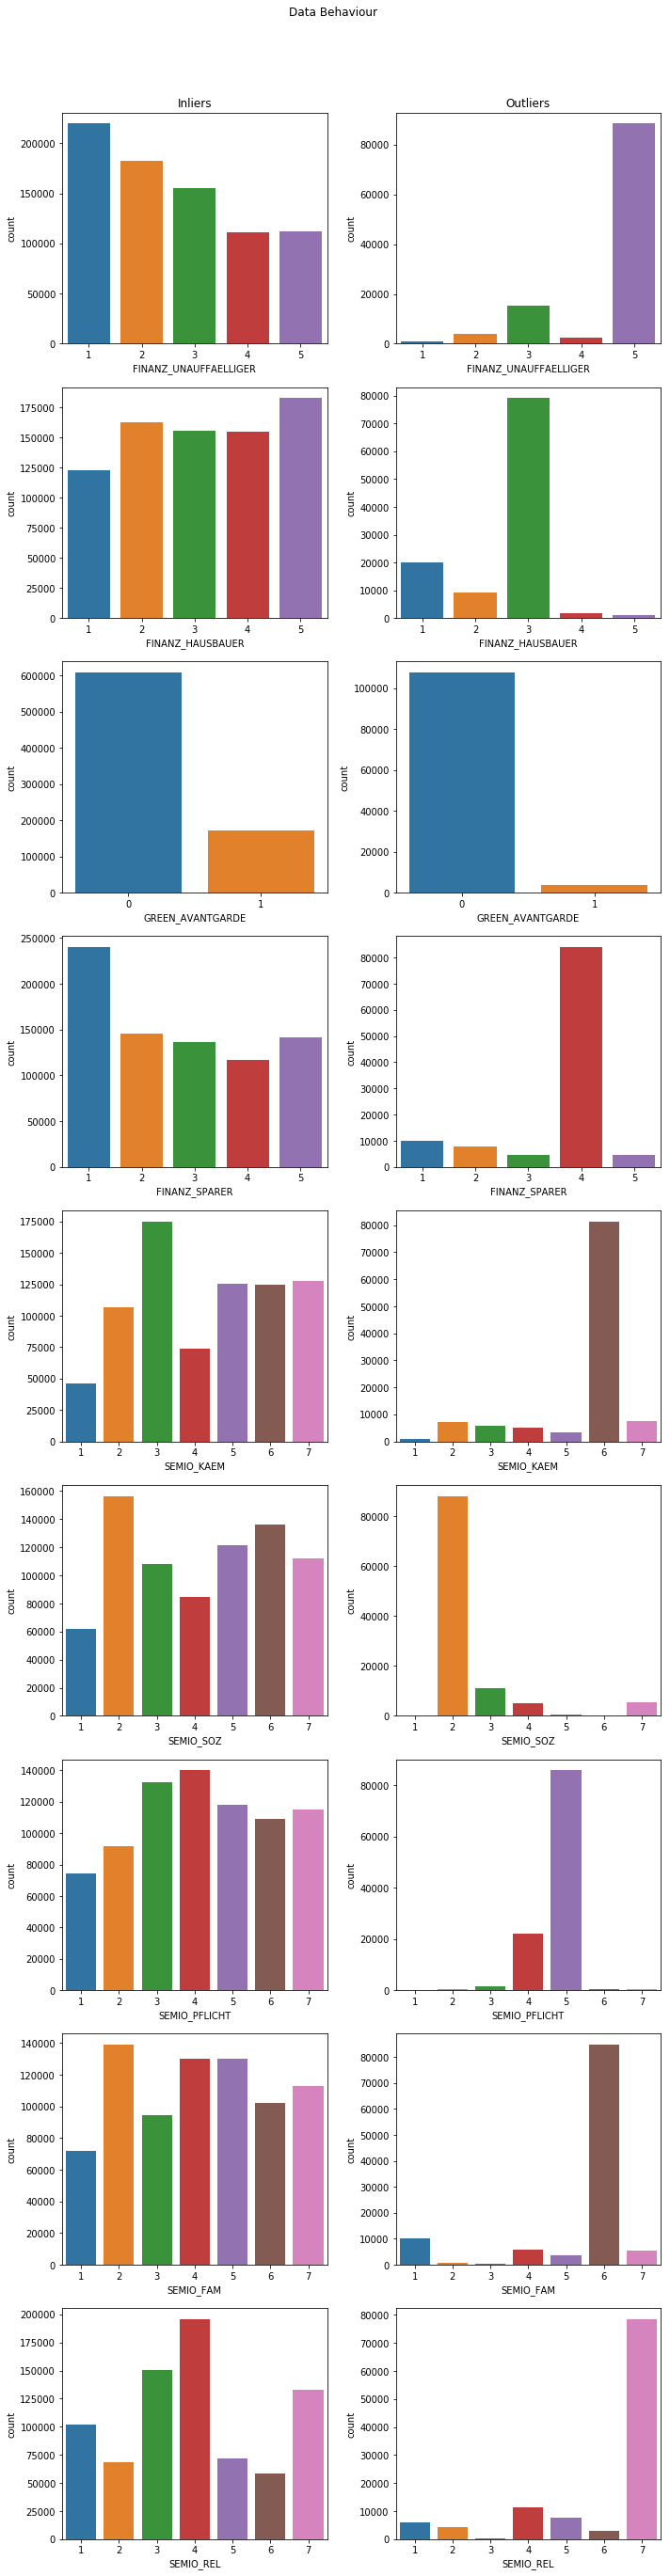

In [36]:
plot_cols_count_comparison(_azdias,_az_outliers,'Inliers','Outliers',non_missing_columns)

In [37]:
# _azdias.info()

#### Discussion 1.1.3: Assess Missing Data in Each Row

As we stated previously, there is no evidence of correlation between Outliers respecting to Inliers behaviour on theses non-missing-attributes. So it leads us to conclude that we can discard Outliers and keep Analysis with Inliers only.
We could afterwards get this set of Outliers and do a separate analysis, to get more information about this group. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [38]:
# How many features are there of each data type?
feat_info.groupby(['type']).count()

,attribute,information_level,missing_or_unknown,description
type,,,,
categorical,21,21,21,21
encoded,8,8,8,8
interval,1,1,1,1
mixed,7,7,7,7
numeric,7,7,7,7
ordinal,49,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categoricals = feat_info.loc[feat_info['type']=='categorical']['attribute']
categoricals = list(categoricals) 
# remove droped cols
categoricals = [x for x in categoricals if not x in dropped_cols]

In [40]:
def plot_cols_count(df,label1,features=[], figsize=(10,40)):
    """
    Same as plot_missing_by_rows but with features
    """
    title="Data Behaviour "
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)
    
    
    axes = fig.subplots(int(len(features)/2),2)
    
    for i,ff in enumerate(features):
        j = i%2
        k = int(i/2)
        if j == 0:
            countplot_by_attr(df,ff,axes[k][0])
        else:
            countplot_by_attr(df,ff,axes[k][1])
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.show()

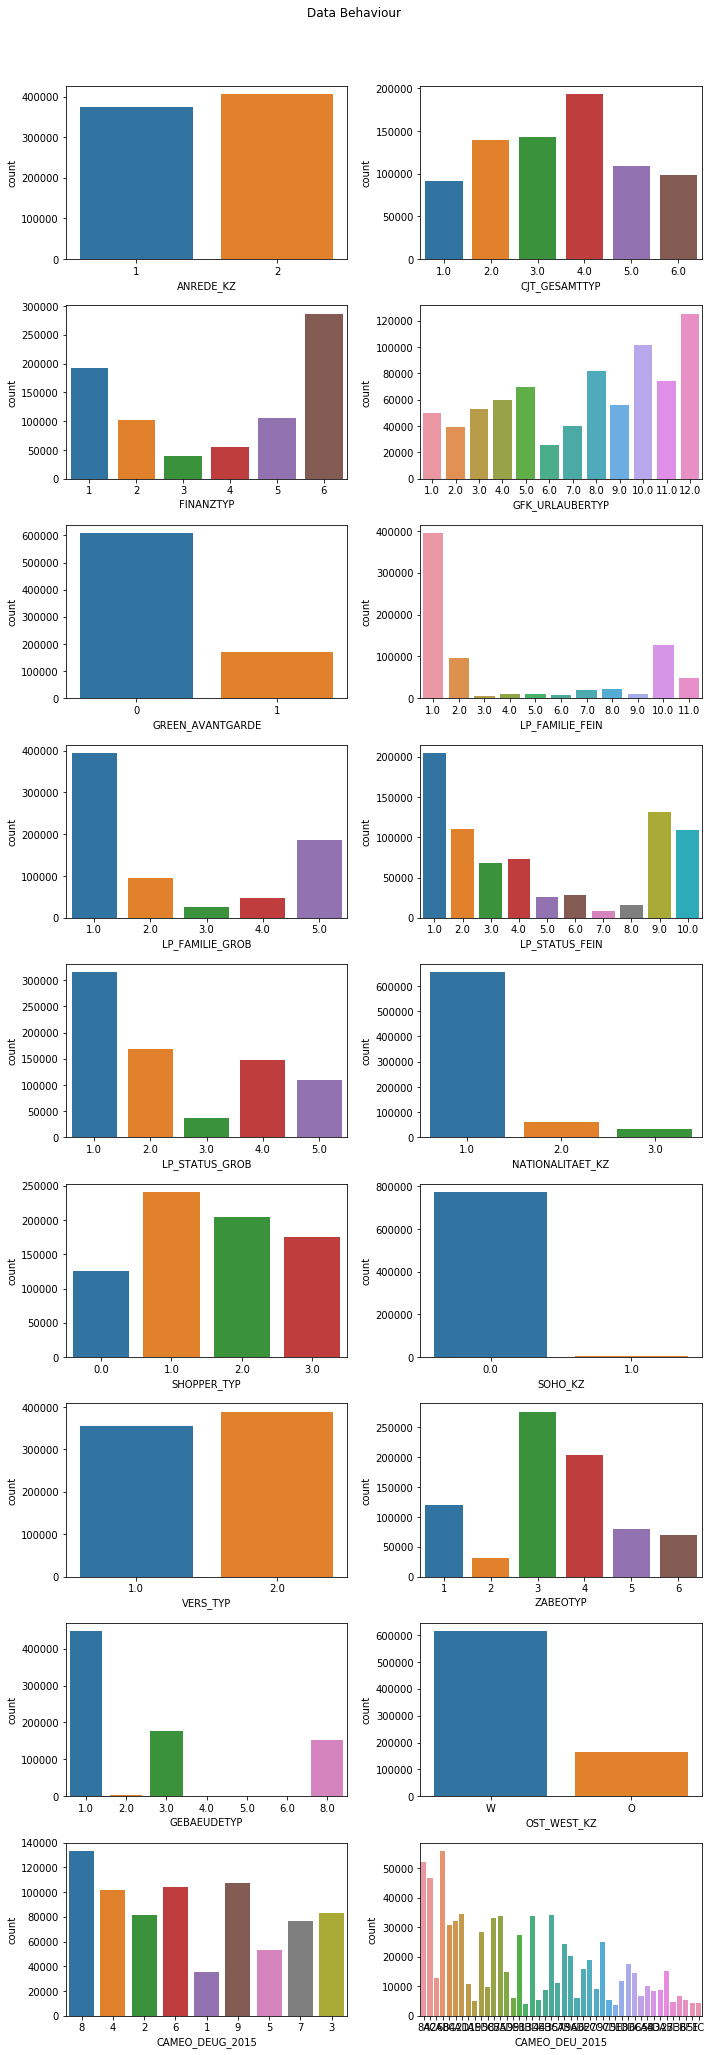

In [41]:
plot_cols_count(_azdias,'azdias',categoricals,figsize=(10,30))

In [42]:
## See what types in columns we have
# _azdias.info(verbose=False)

In [43]:
# Those with object type probably needs to be re encoded
object_cols = _azdias.columns[_azdias.dtypes == "object"]
object_cols

Index(['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015'], dtype='object')

In [44]:
def feat_eng_cat_OST_WEST_KZ(df):
    """
    Re encode the feature "OST_WEST_KZ"
    """
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    print('Re encoding %s  ... '% ('OST_WEST_KZ'))
    
    return df


In [45]:
def feat_eng_cat_ANREDE_KZ(df):
    """
    Re encode the feature "ANREDE_KZ"
    """
    df['ANREDE_KZ'] = df['ANREDE_KZ'].replace({1: 0, 2: 1})
    
    print('Re encoding %s  ... '% ('ANREDE_KZ'))
    
    return df

In [46]:
def get_info(df, attribute):
    print(df[attribute].value_counts(sort=True,dropna=True)) 
    df[attribute].hist()

### LP_STATUS_GROB

1.0    314706
2.0    167999
4.0    147048
5.0    109300
3.0     37266
Name: LP_STATUS_GROB, dtype: int64


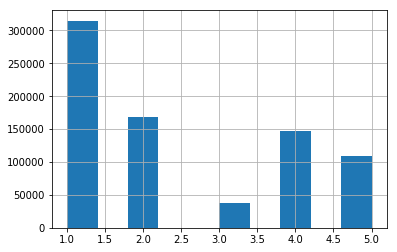

In [47]:
get_info(_azdias,'LP_STATUS_GROB')

In [48]:
def feat_eng_cat_LP_STATUS_GROB(df):
    
    df_ = pd.get_dummies(df["LP_STATUS_GROB"],prefix="LP_STATUS_GROB",drop_first=True)
    
    df = df.join(df_)
    
    print('One Hot Encoding %s ... '% ('LP_STATUS_GROB'))
    
    df = df.drop(columns=['LP_STATUS_GROB'], errors='ignore')
    
    print('Removing %s  ... '% ('LP_STATUS_GROB'))
    
    return df

### LP_FAMILIE_GROB

1.0    395060
5.0    185701
2.0     96151
4.0     47774
3.0     26617
Name: LP_FAMILIE_GROB, dtype: int64


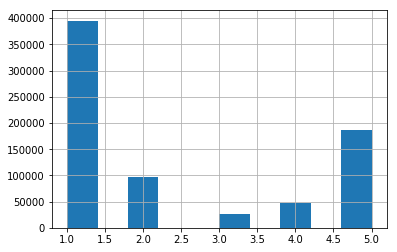

In [49]:
get_info(_azdias,'LP_FAMILIE_GROB')

In [50]:
def feat_eng_cat_LP_FAMILIE_GROB(df):
    
    df_ = pd.get_dummies(df["LP_FAMILIE_GROB"],prefix="LP_FAMILIE_GROB",drop_first=True)
    
    df = df.join(df_)
    
    print('One Hot Encoding %s ... '% ('LP_FAMILIE_GROB'))
    
    df = df.drop(columns=['LP_FAMILIE_GROB'], errors='ignore')
    
    print('Removing %s  ... '% ('LP_FAMILIE_GROB'))
    
    return df

### SHOPPER_TYP

1.0    240864
2.0    204009
3.0    174506
0.0    126250
Name: SHOPPER_TYP, dtype: int64


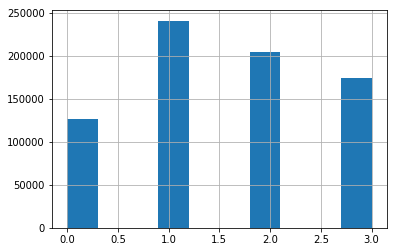

In [51]:
get_info(_azdias,'SHOPPER_TYP')


In [52]:
def feat_eng_cat_SHOPPER_TYP(df):
    
    df_ = pd.get_dummies(df["SHOPPER_TYP"],prefix="SHOPPER_TYP",drop_first=True)
    
    df = df.join(df_)
    print('One Hot Encoding %s  ... '% ('SHOPPER_TYP'))
    
    df = df.drop(columns=['SHOPPER_TYP'], errors='ignore')
    
    print('Removing %s  ... '% ('SHOPPER_TYP'))
    
    return df

### CJT_GESAMTTYP

4.0    193491
3.0    143625
2.0    139638
5.0    109291
6.0     98948
1.0     91326
Name: CJT_GESAMTTYP, dtype: int64


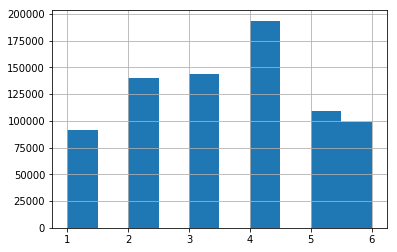

In [53]:
get_info(_azdias,'CJT_GESAMTTYP')


In [54]:
def feat_eng_cat_CJT_GESAMTTYP(df):
    
    df_ = pd.get_dummies(df["CJT_GESAMTTYP"],prefix="CJT_GESAMTTYP",drop_first=True)
    
    df = df.join(df_)
    
    print('One Hot Encoding %s ... '% ('CJT_GESAMTTYP'))
    
    df = df.drop(columns=['CJT_GESAMTTYP'],errors='ignore')
    
    print('Removing %s  ... '% ('CJT_GESAMTTYP'))
    
    return df

In [55]:
# Re-encode categorical variable(s) to be kept in the analysis.

# _azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# azdias = feat_eng_OST_WEST_KZ(_azdias)
# azdias = feat_eng_ANREDE_KZ(_azdias)

# _azdias= feat_eng_cat_SHOPPER_TYP(_azdias)
# _azdias= feat_eng_cat_CJT_GESAMTTYP(_azdias)
# _azdias= feat_eng_cat_LP_STATUS_GROB(_azdias)
# _azdias= feat_eng_cat_LP_FAMILIE_GROB(_azdias)



In [56]:
_azdias.shape

(780153, 79)

In [57]:
# Discard categorical variables to the Analysis
categorical_discard = ['GFK_URLAUBERTYP','NATIONALITAET_KZ','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015',\
                       'FINANZTYP','CAMEO_DEU_2015','LP_FAMILIE_FEIN','LP_STATUS_FEIN']  
    
_azdias = _azdias.drop(categorical_discard, axis=1, errors='ignore')
_customers = _customers.drop(categorical_discard, axis=1, errors='ignore')

#### Discussion 1.2.1: Re-Encode Categorical Features

- Binaries:

    - I will keep all binaries `OST_WEST_KZ, ANREDE_KZ GREEN_AVANTGARDE, VERS_TYP`
    - `OST_WEST_KZ, ANREDE_KZ` were reencoded to [0,1] 
    <br><br>
    
- Multilevel:
<br><br>
    - Keeped : 
<br><br>
        - `LP_FAMILIE_FEIN` and `LP_STATUS_FEIN` are too granular, I discard them and keep `LP_FAMILIE_GROB` and `LP_STATUS_GROB`with same info less granular so we reduce number of classes from 10 and 11 respectively to 4, as explained in description .md <br>

        - I will firstly re encode(group and reduce classes) and secondly One Hot Encode some multi-level of interest : <br>

            - 
            - `LP_FAMILIE_GROB` and `LP_STATUS_GROB`
            - `SHOPPER_TYP` (shoper type)
            - `CJT_GESAMTTYP`(consumer type)
<br><br>
    - Discarded: 
<br><br>
        - `FINANZTYP` even though is described as 'most descriptive financial type for people' , there are one feature Ordinal for each type (ie. `FINANZ_MINIMALIST`, etc ..) so we already got that info. 
        - `NATIONALITAET_KZ` seems to have skewed distribution (mostly Germans) so dont seem to add essential info and it is based in analysis of the names so I decide that may be a weak attribute and discard it.
        - `CAMEO_DEU_2015` and `CAMEO_DEUG_2015` are too granular and I assume got that info in `CAMEO_INTL` so I decide to drop them.
        - `GEBAEUDETYP` is a building residential type, but we got a few others representing that family of info `ANZ_` so discarded
        - `ZABEOTYP` and `GFK_URLAUBERTYP` have too many classes and already represented in personallevel info
          
          

### Categorical Variables - Analysis and Actions taken

 | Index | Attribute | Feature | Category | Action |
| --- | --- | --- | --- | --- |
| 0 |             AGER_TYP |  Best-ager typology | multi |  NAN discarded|
| 2 |            ANREDE_KZ |  Gender |  bin | <b>ReEncode to [0,1]</b> |
| 3 |        CJT_GESAMTTYP | Customer-Journey-Typology    | multi   |   <b>OHE </b> |
| 10 |          FINANZTYP |  Most descriptive financial type for individual    | multi   |  <b>OHE </b> |
| 12 |    GFK_URLAUBERTYP |  Vacation habits   | multi   |DISCARD too many|
| 13 | GREEN_AVANTGARDE |    Membership in environmental sustainability     |  bin | none|
| 17 |    LP_FAMILIE_FEIN |  Family type, fine scale   | multi   | DISCARD too many and represented by GROB |
| 18 |    LP_FAMILIE_GROB | Family type, rough scale    | multi   |   <b>OHE</b> |
| 19 |     LP_STATUS_FEIN |  Social status, fine scale   | multi   | DISCARD too many and represented by GROB |
| 20 |     LP_STATUS_GROB |  Social status, rough scale    | multi   |  <b>OHE</b> |
| 21 | NATIONALITAET_KZ |    Nationality based on given name analysis    | multi   | DISCARD |
| 38 |        SHOPPER_TYP | Shopper typology    | multi   | <b>OHE</b>|
| 39 |            SOHO_KZ |  Small office / home office flag   | bin  | none|
| 40 |           TITEL_KZ |  Academic title flag    | multi   |  NAN discarded|
| 41 |           VERS_TYP |  Insurance typology   | bin | none|
| 42 |           ZABEOTYP | Energy consumption    | multi   |  DISCARD too many |
| 47 |       KK_KUNDENTYP |  Consumer pattern over past 12 months    | multi   |  NAN discarded |
| 52 |        GEBAEUDETYP | Type of building (residential vs. commercial)    | multi   | DISCARD, repr by other 5 |
| 55 |        OST_WEST_KZ |  Building location    |  bin |  <b>Re Encode to 0-1</b>|
| 57 |    CAMEO_DEUG_2015 |  German CAMEO: Wealth / Life Stage Typology rough scale   | multi   | DISCARD too many and repr by CAMEO_INTL |
| 58 |     CAMEO_DEU_2015 |  German CAMEO: Wealth / Life Stage Typology detailed scale   | multi   |DISCARD too many and repr by CAMEO_INTL |


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [58]:
mixed = feat_info.loc[feat_info['type']=='mixed']['attribute']
# remove droped cols
mixed = [x for x in mixed if not x in dropped_cols]


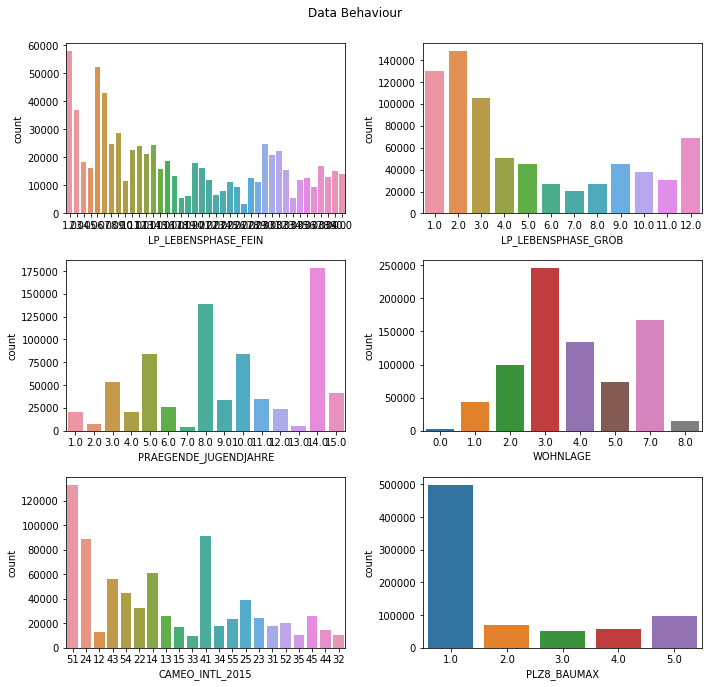

In [59]:
plot_cols_count(_azdias,'azdias',mixed,figsize=(10,10))

In [60]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

######  PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
- ..
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


In [61]:

def feat_eng_mix_PJ(df):
    '''
    * PRAEGENDE_JUGENDJAHRE splits into YOUTH_DECADE and YOUTH_MOVEMENT.
    '''
    # Target column to be transformed:
    feat = 'PRAEGENDE_JUGENDJAHRE'

    pj = df[feat]
    
    df['YOUTH_DECADE'] = [4 if pj.iloc[i] in [1, 2] \
                          else 5 if pj.iloc[i] in [3, 4] \
                          else 6 if pj.iloc[i] in [5, 6, 7] \
                          else 7 if pj.iloc[i] in [8, 9] \
                          else 8 if pj.iloc[i] in [10, 11, 12, 13] \
                          else 9 if pj.iloc[i] in [14, 15] \
                          else np.nan for i in range(df.shape[0])]

    df['YOUTH_MOVEMENT'] = [0 if pj.iloc[i] in [1, 3, 5, 8, 10, 12, 14] \
                         else 1 if pj.iloc[i] in [2, 4, 6, 7, 9, 11, 13, 15] \
                         else np.nan for i in range(df.shape[0])]
     
    # Deleting original column:
    df = df.drop(columns = [feat], errors = 'ignore')
   
    print('Creating %s , %s ... '% ('YOUTH_DECADE','YOUTH_MOVEMENT'))
    print('Removing %s  ... '% ('PRAEGENDE_JUGENDJAHRE'))
    
    return df

In [62]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.


###### CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- ...
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [63]:
def feat_eng_mix_CAMEO_INTL(df):
    '''
    * CAMEO_INTL_2015 splits into CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_STAGE.
    '''
   
    # Target column to be transformed:
    feat = 'CAMEO_INTL_2015'
    
    cameo =df[feat]
    
    df['CAMEO_INTL_2015_WEALTH'] = [int(cameo.iloc[i][0]) if isinstance(cameo.iloc[i],str) else np.nan for i in range(df.shape[0])]
    
    df['CAMEO_INTL_2015_STAGE'] =  [int(cameo.iloc[i][1]) if isinstance(cameo.iloc[i],str) else np.nan for i in range(df.shape[0])]
    
    # Deleting original column:
    df = df.drop(columns = [feat], errors = 'ignore')
    
    print('Creating %s , %s ... '% ('CAMEO_INTL_2015_WEALTH','CAMEO_INTL_2015_STAGE'))
    print('Removing %s  ... '% ('CAMEO_INTL_2015'))
    
    return df

In [64]:
# azdias = feat_eng_mix_PJ(_azdias)

In [65]:
# azdias = feat_eng_mix_CAMEO_INTL(_azdias)

In [66]:
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [67]:
mixed_discard= ['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

In [68]:
def feat_eng_mix_LP(df):
    """
    Re encode to split and reduce classes of "LP_LEBENSPHASE_FEIN"
    """
    
    
    # LP_LEBENSPHASE_FEIN
    life_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df["LP_LEBENSPHASE_WEALTH"] = df["LP_LEBENSPHASE_FEIN"]
    
    df["LP_LEBENSPHASE_STAGE"] = df["LP_LEBENSPHASE_FEIN"].map(life_stages)
    df["LP_LEBENSPHASE_WEALTH"] = df["LP_LEBENSPHASE_WEALTH"].map(wealth_scale)
    
    
   
    life_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
    wealth_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}
    
    df["LP_LEBENSPHASE_STAGE"] = df["LP_LEBENSPHASE_STAGE"].map(life_stages)
    df["LP_LEBENSPHASE_WEALTH"] = df["LP_LEBENSPHASE_WEALTH"].map(wealth_scale)
    
    df = df.drop(columns=['LP_LEBENSPHASE_FEIN'], errors = 'ignore')
    
    print('Creating %s , %s ... '% ('LP_LEBENSPHASE_STAGE','LP_LEBENSPHASE_WEALTH'))
    print('Removing %s ... '% ('LP_LEBENSPHASE_FEIN'))
    
    return df

In [69]:
_azdias = _azdias.drop(mixed_discard ,axis=1)
_customers = _customers.drop(mixed_discard ,axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

- Mixed Features

    - `CAMEO_INTL_2015` was splitted into 2 new categories `CAMEO_INTL_2015_WEALTH` and `CAMEO_INTL_2015_STAGE`, as code was of two digits like [wealth][life stage] , just getting one or another splits the data
    - `PRAEGENDE_JUGENDJAHRE` was splitted into 2 new categories `YOUTH_DECADE` and `YOUTH_MOVEMENT`. Here the splitting was hardcoded according Attributes Dictionary .md description
    -  `LP_LEBENSPHASE_FEIN` was splitted into `WEALTH` and `STAGE` same as CAMEO, and `_GLOB` was dropped. The decision was made as _GLOB has those categories merged, whereas _FEIN has a good granularity and was able to separate and rescale to just 4 `'ordinalish'` categories in each class
    - `PLZ8_BAUMAX` has many classes and is represented in other PLZ8 family so we discard it
    - `WOHNLAGE` discarded too

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [70]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [71]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [119]:
def clean_data(df, feat_info, verbose=False):
    """
    Perform feature trimming, re-encoding, and engineering for a Demographics or Customers Data
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    df = populate_nans(df, feat_info, verbose=verbose)
    
    # remove selected columns and rows, ...
        # remove columns => with > 30% nans
    dropped_cols = ['TITEL_KZ','KK_KUNDENTYP','KBA05_BAUMAX','ALTER_HH','AGER_TYP','GEBURTSJAHR']
    df.drop(columns = dropped_cols, axis=1, inplace=True, errors = 'ignore')
    
    print('Droped %s' % dropped_cols)

    
    # select, re-encode, and engineer column values.
    
    print('   ')
        # remove outliers => rows with > 10 nan features
    df, outliers = split_outliers(df)
    print('   ')
        #categorical
    df = feat_eng_cat_OST_WEST_KZ(df)
    df = feat_eng_cat_ANREDE_KZ(df)
    print('   ')
    
    df= feat_eng_cat_SHOPPER_TYP(df)
    df= feat_eng_cat_CJT_GESAMTTYP(df)
    df= feat_eng_cat_LP_STATUS_GROB(df)
    df= feat_eng_cat_LP_FAMILIE_GROB(df)
    print('   ')

    categorical_discard = ['GFK_URLAUBERTYP','NATIONALITAET_KZ','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015',\
                       'FINANZTYP','CAMEO_DEU_2015','LP_FAMILIE_FEIN','LP_STATUS_FEIN']  
    
    df.drop(columns = categorical_discard, axis=1, inplace=True, errors = 'ignore')
    
    print('Droped %s' % categorical_discard)
    print('   ')
    
        #mixed
    df = feat_eng_mix_PJ(df)
    df = feat_eng_mix_CAMEO_INTL(df)
    df = feat_eng_mix_LP(df)
    
    mixed_discard= ['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
    df.drop(columns = mixed_discard ,axis=1, inplace=True, errors = 'ignore')
    
    print('Droped %s' % mixed_discard)
    
    print('\n Finished ......................... OK')
    
    # Return the cleaned dataframe.
    
    return df


In [120]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

In [121]:
azdias = clean_data(azdias, feat_info, verbose=True)

Replacing unknown/missing codes with NANs ........please wait 
Replacing ['-1', '0'] to NaN in Attribute AGER_TYP
Replacing ['-1', '0', '9'] to NaN in Attribute ALTERSKATEGORIE_GROB
Replacing ['-1', '0'] to NaN in Attribute ANREDE_KZ
Replacing ['0'] to NaN in Attribute CJT_GESAMTTYP
Replacing ['-1'] to NaN in Attribute FINANZ_MINIMALIST
Replacing ['-1'] to NaN in Attribute FINANZ_SPARER
Replacing ['-1'] to NaN in Attribute FINANZ_VORSORGER
Replacing ['-1'] to NaN in Attribute FINANZ_ANLEGER
Replacing ['-1'] to NaN in Attribute FINANZ_UNAUFFAELLIGER
Replacing ['-1'] to NaN in Attribute FINANZ_HAUSBAUER
Replacing ['-1'] to NaN in Attribute FINANZTYP
Replacing ['0'] to NaN in Attribute GEBURTSJAHR
Replacing [] to NaN in Attribute GFK_URLAUBERTYP
Replacing [] to NaN in Attribute GREEN_AVANTGARDE
Replacing ['-1', '0'] to NaN in Attribute HEALTH_TYP
Replacing ['0'] to NaN in Attribute LP_LEBENSPHASE_FEIN
Replacing ['0'] to NaN in Attribute LP_LEBENSPHASE_GROB
Replacing ['0'] to NaN in Attrib

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Re encoding OST_WEST_KZ  ... 
Re encoding ANREDE_KZ  ... 
   
One Hot Encoding SHOPPER_TYP  ... 
Removing SHOPPER_TYP  ... 
One Hot Encoding CJT_GESAMTTYP ... 
Removing CJT_GESAMTTYP  ... 
One Hot Encoding LP_STATUS_GROB ... 
Removing LP_STATUS_GROB  ... 
One Hot Encoding LP_FAMILIE_GROB ... 
Removing LP_FAMILIE_GROB  ... 
   
Droped ['GFK_URLAUBERTYP', 'NATIONALITAET_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'FINANZTYP', 'CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
   
Creating YOUTH_DECADE , YOUTH_MOVEMENT ... 
Removing PRAEGENDE_JUGENDJAHRE  ... 
Creating CAMEO_INTL_2015_WEALTH , CAMEO_INTL_2015_STAGE ... 
Removing CAMEO_INTL_2015  ... 
Creating LP_LEBENSPHASE_STAGE , LP_LEBENSPHASE_WEALTH ... 
Removing LP_LEBENSPHASE_FEIN ... 
Droped ['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

 Finished ......................... OK


In [75]:
# azdias.info()

In [76]:
# customers.info()

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

#### Imputing Nans 



In [122]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# sklearn.imputer.SimpleImputer in newer versions !
imputer = Imputer(strategy="most_frequent")

azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)


In [123]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

scaler.fit(azdias)

azdias = pd.DataFrame(scaler.transform(azdias), columns = azdias.columns)


### Discussion 2.1: Apply Feature Scaling

- Firstly I impute Nans with Imputer strategy mean, as we got all numeric data after the feature engineering process.
- After that I applied a Standard Scaler for Scaling



### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [79]:
# azdias_pca, azdias_X_pca = do_pca(None, azdias)

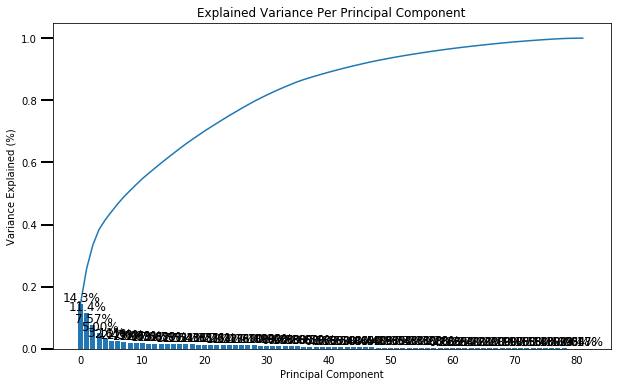

In [80]:
# Investigate the variance accounted for by each principal component.
# scree_plot(azdias_pca)

In [124]:
# Re-apply PCA to the data while selecting for number of components to retain.
azdias_pca, azdias_X_pca = do_pca(60, azdias)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

From the plots I see that with firsts 50 PCs Variance explained reaches 90%.




### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components).<b>The further a weight is from zero, the more the principal component is in the direction of the corresponding feature.</b><b> If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.</b>

- To investigate the features, <b>you should map each weight to their corresponding feature name</b>, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should <b>investigate and interpret feature associations from the first three principal components in this substep.</b> To help facilitate this, you should write a <b>function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component</b>. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [126]:
def plot_weights(df, pca, feat_info, component, n_weights = 3, figsize=(7,4)):
    """
    This function displays interesting features of the selected Component 
    """
    
    features = df.columns.values
    components = pca.components_
    
    # get the features weights for the selected component 
    weights = dict(zip(features, components[component]))
    # sort descending, heavier first
    sorted_weights = sorted(weights.items(), key = lambda v: v[1], reverse=True)
    
    feat_names = []
    feat_weights = []
    feat_level = []
    feat_descs = []

    # get the firsts heavier n_weights
    for feat, weight in sorted_weights[:n_weights]:
        feat_names.append(feat)
        feat_weights.append(weight)
    # get the lasts heavier (negative) n_weights
    for feat, weight, in sorted_weights[-n_weights:]:
        feat_names.append(feat)
        feat_weights.append(weight)

    # add info level and description for analysis
    for feat in feat_names:
        if feat in feat_info.attribute.values:
            feat_level.append(feat_info[feat_info.attribute == feat].information_level.values[0])
            feat_descs.append(feat_info[feat_info.attribute == feat].description.values[0])
        else:
            feat_descs.append("Missing Attribute")
            feat_level.append("Missing Attribute")
    

    comp_info = {"Feature":feat_names, "Weight":feat_weights,  "Information Level":feat_level, "Description": feat_descs }
    comp_info = pd.DataFrame(comp_info)
    comp_info.sort_values("Weight", inplace=True, ascending=False)
    
    # Plot 
    df =pd.DataFrame(list(zip(feat_names,feat_weights))).set_index(0)
    ax = df.plot.bar(figsize=figsize, title="PCA Feature weights - Component {}".format(component),\
                grid=True,layout=(2,4),legend=False,rot=45)
    
    ax.set_ylabel("Feature Weight")
    ax.set_xlabel("Feature Name")

    plt.show()

    return comp_info

In [83]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 5 columns):
attribute             93 non-null object
information_level     93 non-null object
type                  93 non-null object
missing_or_unknown    93 non-null object
description           93 non-null object
dtypes: object(5)
memory usage: 3.7+ KB


### Discussion 2.3: Interpret Principal Components

For a complete visualization, see the plots below 
    
- <b>Component 0</b> : This is a macro-cell (Housing) oriented component with some financial features

    - (+) Weights:  
        - Number of 6 -10 and +10 family houses in the PLZ8 region
        - Estimated household net income
    - (-) Weights:
        - Number of 1-2 family houses in the microcell
        - Movement patterns
        - Financial typology, 'MINIMALIST' or low financial interest
        

- <b>Component 1</b> : This is a Financial Oriented component, with some Life Stage/Age features
    - (+) Weights:  
        - Estimated age based on given name analysis
        - LP_LEBENSPHASE_STAGE = Life Stage related to income/career
        - Financial typology, be prepared or 'VORSORGER', in the middle of SAVER and INVESTOR
    - (-) Weights:
        - Financial typology, inconspicuous, the HIGHEST level in Finance typo
        - Personality typology, religious
        - YOUTH_DECADE : when spend their young ages


- <b>Component 2</b> : This is a clearly a Personality Oriented component
    - (+) Weights:  
        - Personality typology, dreamful
        - Personality typology, socially-minded
        - Personality typology, family minded
    - (-) Weights:
        - Personality typology, dominant-minded
        - Personality typology, combative attitude
        - Gender
        

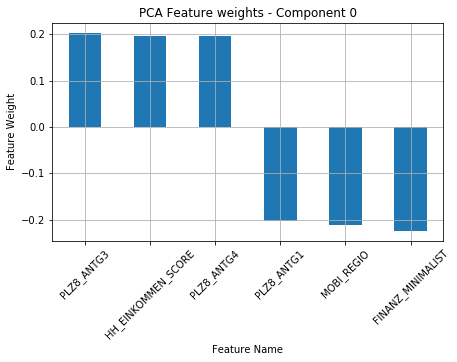

,Feature,Weight,Information Level,Description
0,PLZ8_ANTG3,0.202431,macrocell_plz8,Number of 6 -10 family houses in the PLZ8 region
1,HH_EINKOMMEN_SCORE,0.196401,household,Estimated household net income
2,PLZ8_ANTG4,0.195219,macrocell_plz8,Number of 10+ family houses in the PLZ8 region
3,PLZ8_ANTG1,-0.203115,macrocell_plz8,Number of 1-2 family houses in the PLZ8 region
4,MOBI_REGIO,-0.212141,region_rr1,Movement patterns
5,FINANZ_MINIMALIST,-0.223783,person,"Financial typology, low financial interest"


In [156]:
##### Map weights for the first principal component to corresponding feature names
#  and then print the linked values, sorted by weight.
#  HINT: Try defining a function here or in a new cell that you can reuse in the
#  other cells.

plot_weights(azdias, azdias_pca, feat_info, 0, 3)

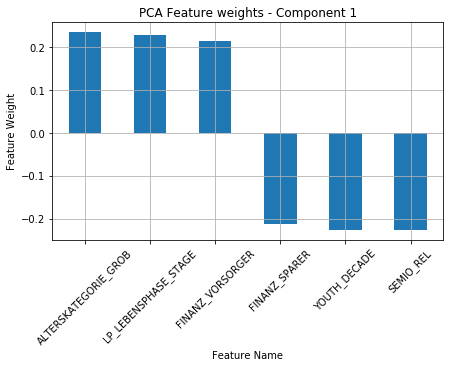

,Feature,Weight,Information Level,Description
0,ALTERSKATEGORIE_GROB,0.233824,person,Estimated age based on given name analysis
1,LP_LEBENSPHASE_STAGE,0.228165,person,"Life stage, fine scale encoded scale 1..4"
2,FINANZ_VORSORGER,0.213897,person,"Financial typology, be prepared"
3,FINANZ_SPARER,-0.212308,person,"Financial typology, money-saver"
4,YOUTH_DECADE,-0.226001,person,person's youth decade
5,SEMIO_REL,-0.226375,person,"Personality typology, religious"


In [128]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_weights(azdias, azdias_pca, feat_info, 1, 3)

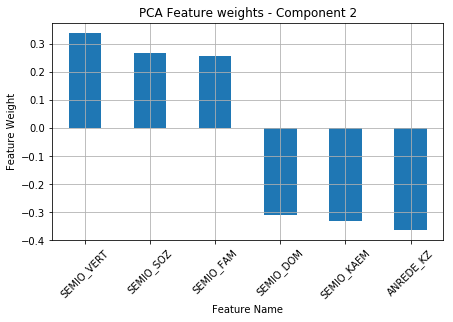

,Feature,Weight,Information Level,Description
0,SEMIO_VERT,0.340446,person,"Personality typology, dreamful"
1,SEMIO_SOZ,0.266154,person,"Personality typology, socially-minded"
2,SEMIO_FAM,0.258333,person,"Personality typology, for each dimension:"
3,SEMIO_DOM,-0.309568,person,"Personality typology, dominant-minded"
4,SEMIO_KAEM,-0.333429,person,"Personality typology, combative attitude"
5,ANREDE_KZ,-0.364915,person,Gender


In [129]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_weights(azdias, azdias_pca, feat_info, 2, 3)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. <b> You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30. </b>
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [130]:
def get_kmeans_scores(df, K_from, K_to, step=1):
    '''
    Function that calculate and plots the Sum of Squared distances to their closest Cluster for [K_from,...,K_to] clusters 
    '''
    n_cluster = range(K_from, K_to, step)
    
    scores = list()
    
    print("Performing K-Means clustering")
    print("Given range min:{}, max:{}, step:{}".format(K_from, K_to, step))
    
    
    for n in n_cluster:
        
        print("\nTraining for n_clusters: ", n)
        start = time.time()
        
        kmeans = KMeans(n_clusters = n)
        kmeans.fit(df)
        scores.append(kmeans.inertia_)
        clusters_dim.append(n)
        
        print("Done... Score: ", scores[-1])
        print("Time elapsed: {:.2f} sec.".format(time.time()-start))
        
    return scores, n_cluster

##### Observation : The get_kmeans_scores is commented as it takes too long training for 10 Kmeans models, instead a checkpoint file kmeans_scores.py was written out and is loaded below 

In [88]:
# Over a number of different cluster counts...
# Kmeans score here
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
# %time
# scores, n_cluster = get_kmeans_scores(azdias_X_pca, 2,20, 2)   

CPU times: user 28 µs, sys: 1e+03 ns, total: 29 µs
Wall time: 7.56 ms


In [120]:
# This is the original output when runned
'''
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs
Performing K-Means clustering
Given range min:2, max:14, step:2

Training for n_clusters:  2
Done... Score:  55420488.2903
Time elapsed: 40.52 sec.

Training for n_clusters:  4
Done... Score:  49509011.5373
Time elapsed: 59.82 sec.

Training for n_clusters:  6
Done... Score:  46400019.9174
Time elapsed: 94.24 sec.

Training for n_clusters:  8
Done... Score:  44229389.9147
Time elapsed: 96.19 sec.

Training for n_clusters:  10
Done... Score:  42930363.7901
Time elapsed: 200.56 sec.

Training for n_clusters:  12
Done... Score:  41699210.9135
Time elapsed: 319.94 sec.

Training for n_clusters:  14
Done... Score:  41260085.2226
Time elapsed: 369.94 sec.

Training for n_clusters:  16
Done... Score:  40166090.9033
Time elapsed: 458.26 sec.

Training for n_clusters:  18
Done... Score:  39421787.5648
Time elapsed: 369.97 sec.
'''
   

'\nCPU times: user 3 µs, sys: 0 ns, total: 3 µs\nWall time: 7.87 µs\nPerforming K-Means clustering\nGiven range min:2, max:14, step:2\n\nTraining for n_clusters:  2\nDone... Score:  55420488.2903\nTime elapsed: 40.52 sec.\n\nTraining for n_clusters:  4\nDone... Score:  49509011.5373\nTime elapsed: 59.82 sec.\n\nTraining for n_clusters:  6\nDone... Score:  46400019.9174\nTime elapsed: 94.24 sec.\n\nTraining for n_clusters:  8\nDone... Score:  44229389.9147\nTime elapsed: 96.19 sec.\n\nTraining for n_clusters:  10\nDone... Score:  42930363.7901\nTime elapsed: 200.56 sec.\n\nTraining for n_clusters:  12\nDone... Score:  41699210.9135\nTime elapsed: 319.94 sec.\n\nTraining for n_clusters:  14\nDone... Score:  41260085.2226\nTime elapsed: 369.94 sec.\n\nTraining for n_clusters:  16\nDone... Score:  40166090.9033\nTime elapsed: 458.26 sec.\n\nTraining for n_clusters:  18\nDone... Score:  39421787.5648\nTime elapsed: 369.97 sec.\n'

In [89]:
def save_scores_checkpoint(scores, n_cluster):
    with open('kmeans_scores.py', 'w') as f:
        for item in scores_:
            f.write("%s," % item)
        f.write("\n")
        for item in n_cluster:
            f.write("%s," % item)
        f.write("\n")

In [90]:
# Save scores to file 
# save_scores_checkpoint(scores, n_cluster)

In [131]:
def load_scores_checkpoint(file):
    with open(file) as f:
        content = f.readlines()
    scores= content[0].split(',')
    n_cluster = content[1].split(',')
    # remove \n and convert to int
    return list(map(float,scores[:-1])), list(map(int,n_cluster[:-1]))

In [132]:
scores,n_clusters = load_scores_checkpoint('kmeans_scores.py')

In [133]:
def plot_kmeans_scores(scores, n_clusters):
    '''
    Function that plots the Sum of the Kmeans scores against the K clusters 
    '''
    
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    
    ax.plot(n_clusters, scores, linestyle= "--",marker = "o", color="orange")
    ax.set_xlabel("Num  of Clusters")
    ax.set_ylabel("Sum of squared distances")
    ax.set_title("Kmeans - Cluster distances vs Num of Clusters")
    
    plt.show()

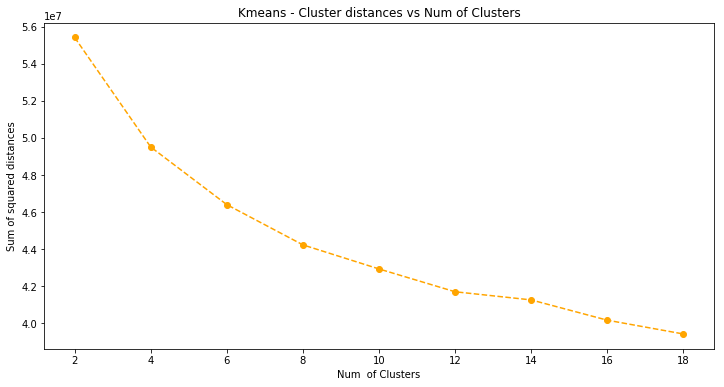

In [134]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plot_kmeans_scores(scores, n_clusters)

#### Choosen the K =  12 now lets do the training and prediction ..

In [135]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(12, random_state=2)
kmeans.fit(azdias_X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=2, tol=0.0001, verbose=0)

In [136]:
azdias_clusters = kmeans.predict(azdias_X_pca)

In [137]:
azdias_clusters = pd.Series(azdias_clusters)

In [138]:
def plot_cluster(clusters):
    '''
    Function that plots clusters predicted by KMeans against its value_counts, in this case Population
    '''
    cluster_info = pd.DataFrame([])
    cluster_info["Population"] = clusters.value_counts().sort_index()
    cluster_info.reset_index(inplace=True)
    cluster_info.rename(columns={"index":"Cluster"}, inplace=True)
    
    fig, (ax1) =  plt.subplots(1,1, figsize=(10, 4))

    ax1.bar(cluster_info["Cluster"], cluster_info["Population"])
    ax1.set_xlabel("Cluster")
    ax1.set_ylabel("No. of People")
    ax1.set_title("General Population")


    fig.suptitle("Cluster Distributions")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return cluster_info

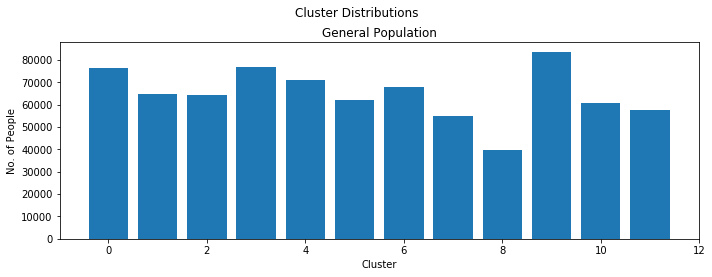

,Cluster,Population
0,0,76372
1,1,64705
2,2,64125
3,3,76919
4,4,71235
5,5,62019
6,6,67861
7,7,54913
8,8,39872
9,9,83680


In [139]:
plot_cluster(azdias_clusters)

### Discussion 3.1: Apply Clustering to General Population

Once reduced the feature dimensionality to 60 Principal Component, I trained a set of KMeans clustering with different K's and analyze the sum of squared distance to the cluster center ( inertia_)  to choose the minimum possible K that minimizes the intra-cluster variation ( elbow method ) 

After ploting these KMeans scores for clusters between 2 and 20 we apply the 'elbows method' and decide to choose K=12 clusters to segment the population, as it is the point where adding more clusters to the algorithm does not minimizes the intra-cluster variance. I add random_state for replicability in the KMeans, and save to a checkpoint file scores as it is a time-consuming operation.

Demographic data seems to be well distributed in the 12 Clusters as shows in the graphic



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. <b>Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data.</b> In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. <b>(You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)</b>
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [140]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [141]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers = clean_data(customers, feat_info)

Replacing unknown/missing codes with NANs ........please wait 
0 ............... ok
10 ............... ok
20 ............... ok
30 ............... ok
40 ............... ok
50 ............... ok
60 ............... ok
70 ............... ok
80 ............... ok
...................... OK 
Droped ['TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'ALTER_HH', 'AGER_TYP', 'GEBURTSJAHR']
   
Removing 52584 outliers rows from df 
Remaining 139068 rows on df 
   


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Re encoding OST_WEST_KZ  ... 
Re encoding ANREDE_KZ  ... 
   
One Hot Encoding SHOPPER_TYP  ... 
Removing SHOPPER_TYP  ... 
One Hot Encoding CJT_GESAMTTYP ... 
Removing CJT_GESAMTTYP  ... 
One Hot Encoding LP_STATUS_GROB ... 
Removing LP_STATUS_GROB  ... 
One Hot Encoding LP_FAMILIE_GROB ... 
Removing LP_FAMILIE_GROB  ... 
   
Droped ['GFK_URLAUBERTYP', 'NATIONALITAET_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'FINANZTYP', 'CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
   
Creating YOUTH_DECADE , YOUTH_MOVEMENT ... 
Removing PRAEGENDE_JUGENDJAHRE  ... 
Creating CAMEO_INTL_2015_WEALTH , CAMEO_INTL_2015_STAGE ... 
Removing CAMEO_INTL_2015  ... 
Creating LP_LEBENSPHASE_STAGE , LP_LEBENSPHASE_WEALTH ... 
Removing LP_LEBENSPHASE_FEIN ... 
Droped ['LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']

 Finished ......................... OK


In [142]:
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

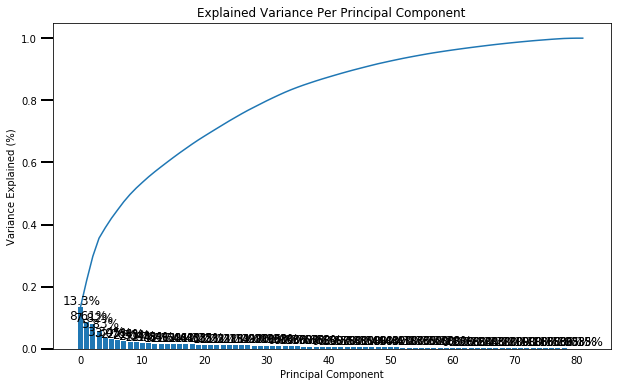

In [143]:
customers_pca, customers_X_pca = do_pca(None, customers)

scree_plot(customers_pca)

In [144]:
customers_pca, customers_X_pca = do_pca(60, customers)

In [145]:
customers_X_pca = azdias_pca.transform(customers)

In [146]:
#kmeans trained with azdias
customers_clusters = kmeans.predict(customers_X_pca)

In [147]:
customers_clusters = pd.Series(customers_clusters)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in <b>step 1.1.3</b> of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. <b>If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis.</b> Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- <b>Which cluster or clusters are overrepresented in the customer dataset </b>compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. <b>Which cluster or clusters are underrepresented in the customer dataset compared to the general population,</b> and what kinds of people are typified by these clusters?

In [148]:
def plot_cluster_comparison(population, customers):
    cluster_info = pd.DataFrame([])
    cluster_info["Population"] = population.value_counts().sort_index()
    cluster_info["Customers"] = customers.value_counts().sort_index()
    cluster_info.reset_index(inplace=True)
    cluster_info.rename(columns={"index":"Cluster"}, inplace=True)
    
    # get % of Population and Customers in each cluster
    cluster_info["Pop_proportion"] = (cluster_info["Population"]/cluster_info["Population"].sum()*100).round(2)
    cluster_info["Cust_proportion"] = (cluster_info["Customers"]/cluster_info["Customers"].sum()*100).round(2)
    # get the Ratio to detect Overrepresented and Underrepresented
    cluster_info["Ratio Customers/Population"] = cluster_info["Cust_proportion"]/cluster_info["Pop_proportion"]

    cluster_info = cluster_info.sort_values(by=["Ratio Customers/Population"],ascending=False)
    
    fig, (ax1,ax2) =  plt.subplots(1,2, figsize=(10, 4))

    ax1.bar(cluster_info["Cluster"], cluster_info["Pop_proportion"])
    ax1.set_xlabel("Cluster")
    ax1.set_ylabel("Proportion of Total (%)")
    ax1.set_title("General Population")

    ax2.bar(cluster_info["Cluster"], cluster_info["Cust_proportion"])
    ax2.set_xlabel("Cluster")
    ax2.set_ylabel("Proportion of Total (%)")
    ax2.set_title("Customers")
    
    
    fig.suptitle("Cluster Distributions")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return cluster_info

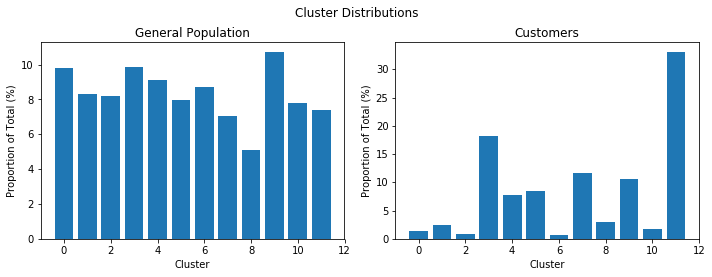

,Cluster,Population,Customers,Pop_proportion,Cust_proportion,Ratio Customers/Population
11,11,57795,46021,7.41,33.09,4.465587
3,3,76919,25395,9.86,18.26,1.851927
7,7,54913,16135,7.04,11.60,1.647727
5,5,62019,11659,7.95,8.38,1.054088
9,9,83680,14761,10.73,10.61,0.988816
4,4,71235,10825,9.13,7.78,0.852136
8,8,39872,4235,5.11,3.05,0.596869
1,1,64705,3500,8.29,2.52,0.303981
10,10,60657,2503,7.78,1.80,0.231362
0,0,76372,1886,9.79,1.36,0.138917


In [149]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plot_cluster_comparison(azdias_clusters,customers_clusters)

##### Ordering Clusters by Ratio Customers/Population helps to detect:
    - Overrepresented Clusters : 11,3,7
    - Underrepresented Clusters : 6,2,0


In [150]:
def cluster_components_info(kmeans, cluster, df, pca, feat_info, num_components=12, num_feat_by_component=3):
    '''
    Function that gets the components weights and its feature weights associated for the selected cluster
    '''
    
    # cluster_centers_ has a shape = [PC/components, features] 
    # ie cluster_centers_[1][3] gives the 'weight' of PC 1 and feature 3
    weights = kmeans.cluster_centers_[cluster]
    # set component numbers
    components = list(range(len(weights)))
    # group both
    cluster_info = pd.DataFrame({"Weights":weights, "Component":components})
    #sort by heaviests
    cluster_info.sort_values("Weights", ascending=False, inplace=True)

    components = []
    weights = []
    comps_info = []
    
    for index, row in cluster_info.head(n=num_components).iterrows():
        
        # get and plot weights for that component
        comp_info = plot_weights(df, pca, feat_info, 
                                                int(row["Component"]), num_feat_by_component)
        # append to list
        comps_info.append(comp_info)
        # 
        components += [int(row["Component"])] * len(comp_info)
        weights +=  [row["Weights"]] * len(comp_info)
        
    component_info = pd.concat(comps_info, ignore_index=True)    
    component_info.insert(0, "ComponentWeight", pd.Series(weights))
    component_info.insert(0, "Component", pd.Series(components))
        
    return component_info

In [111]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

###  Overrepresented Clusters in Customers Data vs Population Data

Here we got the Clusters that contains (in proportion with the total or %) more Customers than Population. In other words `"Popular-Company-Segments"`

We will analyze the <b>11</b> and <b>3</b> here.


#### Cluster 11 

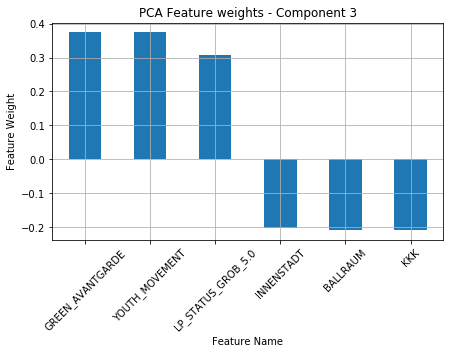

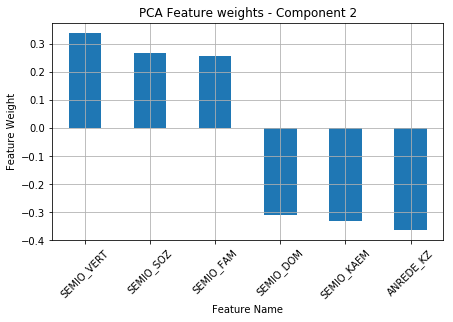

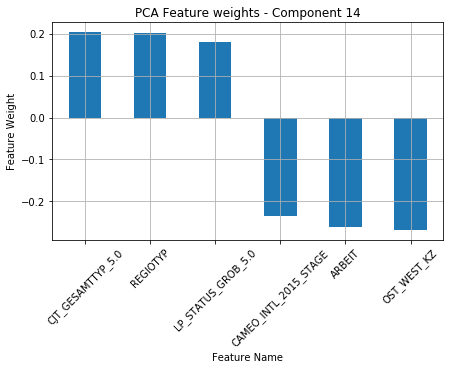

,Component,ComponentWeight,Feature,Weight,Information Level,Description
0,3,2.856098,GREEN_AVANTGARDE,0.373831,person,Membership in environmental sustainability as...
1,3,2.856098,YOUTH_MOVEMENT,0.373831,person,Dominating movement of person's youth (avantga...
2,3,2.856098,LP_STATUS_GROB_5.0,0.307414,Missing Attribute,Missing Attribute
3,3,2.856098,INNENSTADT,-0.203106,postcode,Distance to city center (downtown)
4,3,2.856098,BALLRAUM,-0.207463,postcode,Distance to nearest urban center
5,3,2.856098,KKK,-0.209143,region_rr1,Purchasing power in region
6,2,2.692899,SEMIO_VERT,0.340446,person,"Personality typology, dreamful"
7,2,2.692899,SEMIO_SOZ,0.266154,person,"Personality typology, socially-minded"
8,2,2.692899,SEMIO_FAM,0.258333,person,"Personality typology, for each dimension:"
9,2,2.692899,SEMIO_DOM,-0.309568,person,"Personality typology, dominant-minded"


In [151]:
cluster_11 = cluster_components_info(kmeans, 11, azdias, azdias_pca, feat_info, num_components=3, num_feat_by_component=3)
cluster_11[:19]

#### Cluster 11 Summary

According to the main components 3 and 2, this clusters represents a group of Young people, Greeners and top in earnings scale. People who lives in regions with high purchase power, near to urban centers and city center.

Their Personality (all SEMIO_ have the score inverted from 1:high to 8:low ) tend to be  dominant or combative minded in opposite to a dreamful, social and family minded, Personality and mainly Males.

Component 14 reinforces the top class earners feature, while suggests that a more Customer Adv Enthusiastic characterizes this segment. Additionally, excluding Demanding Shoppers, and people from high unemployment communities, and from Western locations.

Weirdly REGIOTYP(*) that defines neighbourhood typology class appears as a Positive Weight, where we could see a bit of contradiction here, when we plot the feature, we can see nor only in Population but also in Customers Datasets, the distribution is skewed to the right (working class), so it could explain this a bit.

  - Component 3
      - `+` GREEN_AVANTGARDE  => member of green avantgarde
      - `+` YOUTH_MOVEMENT => younger generation
      - `+` LP_STATUS_GROB_5.0 => in the top class of earners
      - `-` KKK => low purchase power
      - `-` INNENSTADT => distance to a city
      - `-` BALLRAUM => distance to nearest urban center
  - Component 2
      - `+` SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM => Personality dreamful, social and family minded
      - `-` SEMIO_DOM , SEMIO_KAEM  => dominant, combative
      - `-` ANREDE_KZ => Males 
  - Component 14
      - `+` CJT_GESAMTTYP_5.0 => Customer Advertising-Enthusiast with restricted Cross-Channel-Behaviour
      - `+` REGIOTYP => Neighborhood typology, from 0:higher to 7:lower class  (*)
      - `+` LP_STATUS_GROB_5.0 => in the top class of earners
      - `-` SHOPPER_TYP_3.0 => Demanding Shopper
      - `-` ARBEIT => high Share of unemployment in community
      - `-` OST_WEST_KZ => more WEST 


Here we can se that `REGIOTYP` is skewed to the right ( working and lower classes ) and is overrrepresented in the Customers data, respecting the Population Data

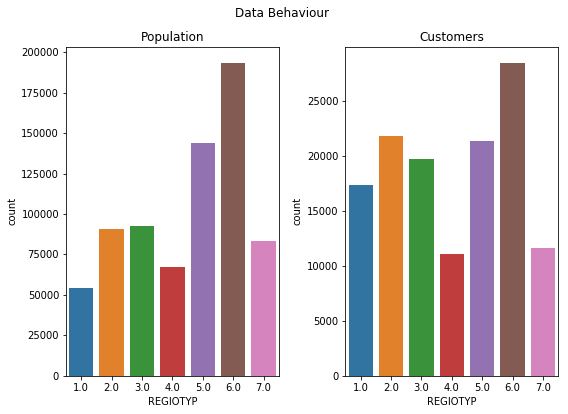

In [113]:
plot_cols_count_comparison(_azdias,_customers,'Population','Customers',features=['REGIOTYP'], figsize=(8,6))


#### Cluster 3 

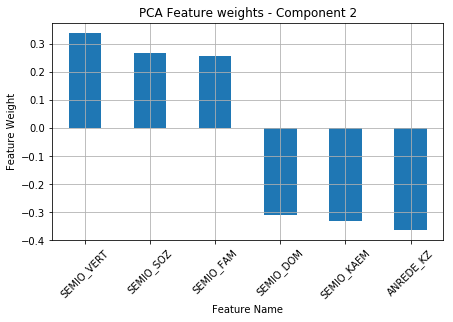

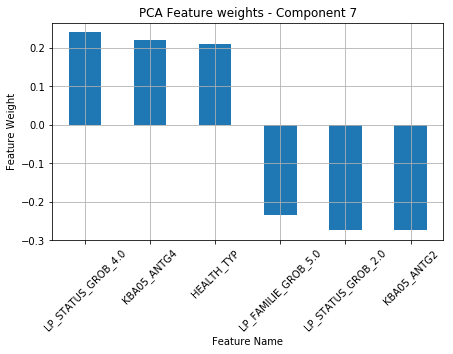

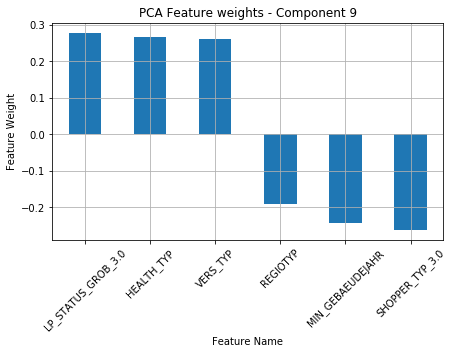

,Component,ComponentWeight,Feature,Weight,Information Level,Description
0,2,1.741168,SEMIO_VERT,0.340446,person,"Personality typology, dreamful"
1,2,1.741168,SEMIO_SOZ,0.266154,person,"Personality typology, socially-minded"
2,2,1.741168,SEMIO_FAM,0.258333,person,"Personality typology, for each dimension:"
3,2,1.741168,SEMIO_DOM,-0.309568,person,"Personality typology, dominant-minded"
4,2,1.741168,SEMIO_KAEM,-0.333429,person,"Personality typology, combative attitude"
5,2,1.741168,ANREDE_KZ,-0.364915,person,Gender
6,7,0.645237,LP_STATUS_GROB_4.0,0.239079,Missing Attribute,Missing Attribute
7,7,0.645237,KBA05_ANTG4,0.218618,microcell_rr3,Number of 10+ family houses in the microcell
8,7,0.645237,HEALTH_TYP,0.208626,person,Health typology
9,7,0.645237,LP_FAMILIE_GROB_5.0,-0.235856,Missing Attribute,Missing Attribute


In [152]:
cluster_3 = cluster_components_info(kmeans, 3, azdias, azdias_pca, feat_info, num_components=3, num_feat_by_component=3)
cluster_3[:19]

#### Cluster 3 Summary

Strongest Component here is the 2, and again it mainly defines the segment by Personality typology. With preference of Dominant and Combative over a Dreamful, Social and Family-minded type, and Male Gender over Female.

Component 7 describe a segment by Neighborhood typology with predominance for lower and working class, social status of HouseOwners, in regions tending to have low power of purchasing. Whereas negative weigths are for lower levels of HouseOwners (FINANZ_HAUSBAUER reinforcing the previous REGIOTYP), high share of 3-5 family houses in the microcell and average earners 

Component 9 reflects independent Social Status and Healthy people. 

- Component 2

    -  `+` SEMIO_VERT   => Personality typology dreamful
    -  `+` SEMIO_SOZ   =>  Personality typology socially-minded
    -  `+` SEMIO_FAM   =>  Personality typology family minded
    -  `-` SEMIO_DOM   =>  Personality typology dominant-minded
    -  `-` SEMIO_KAEM   => Personality typology  combative attitude
    -  `-` ANREDE_KZ   => Gender

- Component 7

    -  `+` REGIOTYP   =>  Neighborhood typology
    -  `+` LP_STATUS_GROB_4   =>  Social status : houseowners
    -  `+` KKK   =>  Purchasing power in region
    -  `-` FINANZ_HAUSBAUER   => Financial typology, home ownership 
    -  `-` KBA05_ANTG2   => Number of 3-5 family houses in the microcell
    -  `-` LP_STATUS_GROB_2   => Social status : average earners

- Component 9
    - `+` LP_STATUS_GROB_3 => independend social status
    - `+` HEALTH_TYP =>   Health typology
    - `+` VERS_TYP =>   Insurance typology
    - `-` REGIOTYP => Neighborhood typology
    - `-` MIN_GEBAEUDEJAHR => First year building was mentioned in the data
    - `-` SHOPPER_TYP_3 => demanding shopper


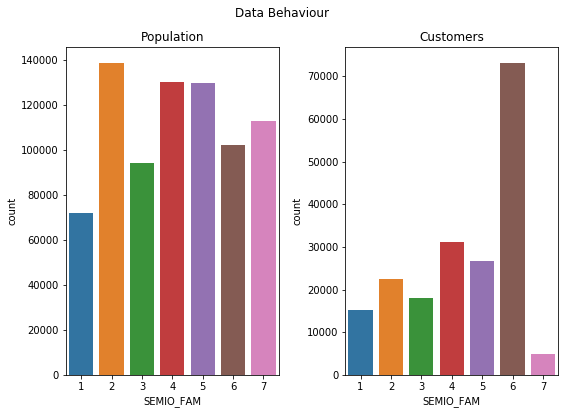

In [115]:
plot_cols_count_comparison(_azdias,_customers,'Population','Customers',features=['SEMIO_FAM'], figsize=(8,6))

###  Underepresented Clusters in Customers Data vs Population Data

Here we got the Clusters that contains (in proportion with the total or %) more Population than Customers. In other words `"Unpopular-Company-Segments"`

We will analyze the <b>6</b> and <b>10</b> here.

In [116]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#### Cluster 6

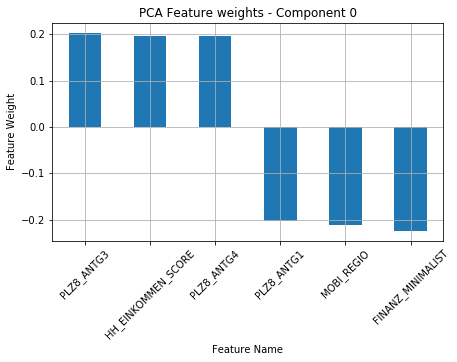

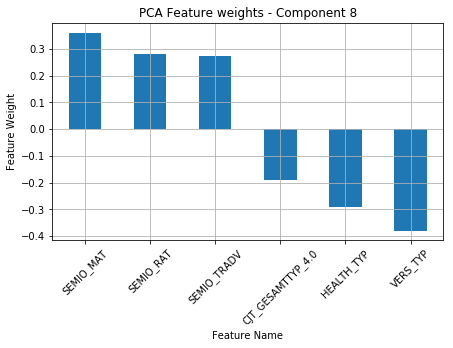

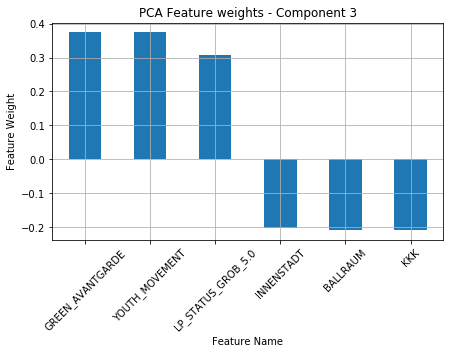

,Component,ComponentWeight,Feature,Weight,Information Level,Description
0,0,4.857415,PLZ8_ANTG3,0.202431,macrocell_plz8,Number of 6 -10 family houses in the PLZ8 region
1,0,4.857415,HH_EINKOMMEN_SCORE,0.196401,household,Estimated household net income
2,0,4.857415,PLZ8_ANTG4,0.195219,macrocell_plz8,Number of 10+ family houses in the PLZ8 region
3,0,4.857415,PLZ8_ANTG1,-0.203115,macrocell_plz8,Number of 1-2 family houses in the PLZ8 region
4,0,4.857415,MOBI_REGIO,-0.212141,region_rr1,Movement patterns
5,0,4.857415,FINANZ_MINIMALIST,-0.223783,person,"Financial typology, low financial interest"
6,8,0.927618,SEMIO_MAT,0.359968,person,"Personality typology, materialistic"
7,8,0.927618,SEMIO_RAT,0.280373,person,"Personality typology, rational"
8,8,0.927618,SEMIO_TRADV,0.273144,person,"Personality typology, tradional-minded"
9,8,0.927618,CJT_GESAMTTYP_4.0,-0.189595,Missing Attribute,Missing Attribute


In [153]:
cluster_6 = cluster_components_info(kmeans, 6, azdias, azdias_pca, feat_info, num_components=3, num_feat_by_component=3)
cluster_6[:19]

#### Cluster 6 Summary 

This `"unpopular-Company"` Cluster segments people living in relatively highly number of family sharing houses as  Component 0 shows in its positive and negative feature weights. 

Lower Householder incomes, high movement patterns and minimalists or money savers financially. 

Regarding Personality typo, we got very low affinity to materialistic, rational and traditional-minded. 

Component 3 describes Greenish and Avantgarded (oposite to Mainstreamed) people,living at shorts Distances to the city and urban centers and between the top earners.

- Component 0

    - `+` PLZ8_ANTG3 => Number of 6 -10 family houses in the PLZ8 region
    - `+` HH_EINKOMMEN_SCORE => Estimated household net income
    - `+` PLZ8_ANTG4 => Number of 10+ family houses in the PLZ8 region
    - `-` PLZ8_ANTG1 => Number of 1-2 family houses in the PLZ8 region
    - `-` MOBI_REGIO => Movement patterns
    - `-` FINANZ_MINIMALIST => Financial typology, low financial

- Component 8 

    - `+` SEMIO_MAT => Personality typology, materialistic
    - `+` SEMIO_RAT => Personality typology, rational
    - `+` SEMIO_TRADV => Personality typology, tradional-minded
    - `-` FINANZ_SPARER => Financial typology, money-saver
    - `-` YOUTH_DECADE => person's youth decade
    - `-` VERS_TYP => Insurance typology

- Component 3

    - `+` GREEN_AVANTGARDE => Membership in environmental sustainability as
    - `+` YOUTH_MOVEMENT => Avantgarde movement
    - `+` LP_STATUS_GROB_5 => Social status, rough scale
    - `-` KKK => Purchasing power in region
    - `-` INNENSTADT => Distance to city center (downtown
    - `-` BALLRAUM => Distance to nearest urban center

#### Cluster 2

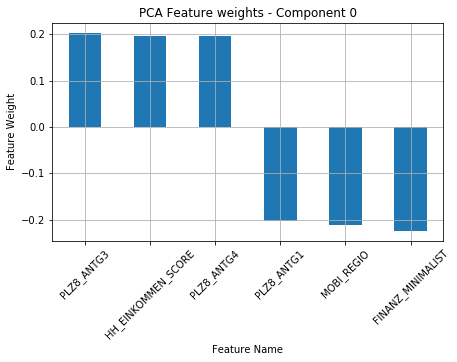

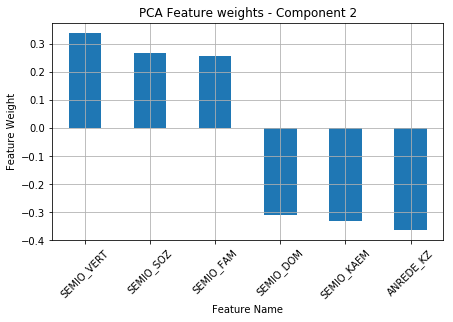

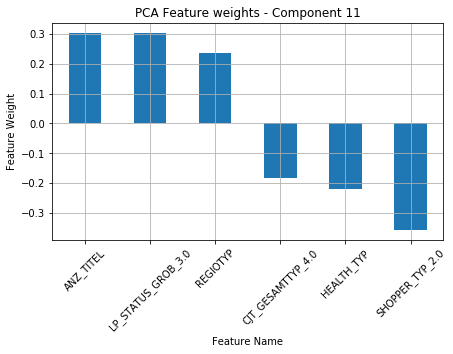

,Component,ComponentWeight,Feature,Weight,Information Level,Description
0,0,4.469556,PLZ8_ANTG3,0.202431,macrocell_plz8,Number of 6 -10 family houses in the PLZ8 region
1,0,4.469556,HH_EINKOMMEN_SCORE,0.196401,household,Estimated household net income
2,0,4.469556,PLZ8_ANTG4,0.195219,macrocell_plz8,Number of 10+ family houses in the PLZ8 region
3,0,4.469556,PLZ8_ANTG1,-0.203115,macrocell_plz8,Number of 1-2 family houses in the PLZ8 region
4,0,4.469556,MOBI_REGIO,-0.212141,region_rr1,Movement patterns
5,0,4.469556,FINANZ_MINIMALIST,-0.223783,person,"Financial typology, low financial interest"
6,2,2.688034,SEMIO_VERT,0.340446,person,"Personality typology, dreamful"
7,2,2.688034,SEMIO_SOZ,0.266154,person,"Personality typology, socially-minded"
8,2,2.688034,SEMIO_FAM,0.258333,person,"Personality typology, for each dimension:"
9,2,2.688034,SEMIO_DOM,-0.309568,person,"Personality typology, dominant-minded"


In [159]:
cluster_2 = cluster_components_info(kmeans, 2, azdias, azdias_pca, feat_info, num_components=3, num_feat_by_component=3)
cluster_2[:19]

#### Cluster 2  Summary 

This Cluster, same as the previous Cluster 6 has its strongest the Component 0.
So againg, this Cluster segments people living in relatively highly number of family sharing houses, with lower Householder incomes, high movement patterns and minimalists or money savers financially.

Interestingly at the Personality level, this Component appears in the 'Company-Popular' Clusters analyzed before. It describes dominant or combative minded in opposite to a dreamful, social and family minded, Personality and mainly Males. 

Finally, Independent workers, with Professional academic titles, and not advertising interested.

- Component 0
    - `+` PLZ8_ANTG3 =>   Number of 6 -10 family houses in the PLZ8   
    - `+` HH_EINKOMMEN_SCORE =>     Estimated household net income
    - `+` PLZ8_ANTG4 =>     Number of 10+ family houses in the PLZ8
    - `-` PLZ8_ANTG1 =>     Number of 1-2 family houses in the PLZ8
    - `-` MOBI_REGIO =>     Movility
    - `-` FINANZ_MINIMALIST =>     Financial typology, low financial interest
- Component 2
    - `+` SEMIO_VERT =>  Personality typology, dreamful
    - `+` SEMIO_SOZ =>  Personality typology, socially-     
    - `+` SEMIO_FAM =>  Personality typology, for      
    - `-` SEMIO_DOM =>  Personality typology, dominant-     
    - `-` SEMIO_KAEM =>  Personality typology, combative      
    - `-` ANREDE_KZ =>     Gender
- Component 11
    - `+` LP_STATUS_GROB_3 => independent workers, title holder (middle)     
    - `+` ANZ_TITEL =>  Number of professional academic title holder    
    - `+` REGIOTYP =>    Neighborhood typology 
    - `-` CJT_GESAMTTYP_4 =>  advertisinginterested Online-shopper 
    - `-` HEALTH_TYP =>  Health typology   
    - `-` SHOPPER_TYP_2 => family-shopper    

### Discussion 3.3: Compare Customer Data to Demographics Data


We have analyzed 2 Popular-Company Clusters and 2 Unpopular-Company Clusters, defining a first step in the segmentation process.

Some fine tuning would be possible to improve the results reached so far, like adding the outliers discarded in the initial process, or removing temporarily the Nans to Scale with no Nans to reincorporate and Impute afterwards. 

Also trying out the .inverse_transform() method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.

Now that we have characterization of more likely customers, the next step would be to build the Supervised Learning model to predict wether a customer should be targetized or not.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.